In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

from shapkit_nbdev.shapley_values import ShapleyValues
from shapkit_nbdev.inspector import inspector
from shapkit_nbdev.monte_carlo_shapley import MonteCarloShapley
from shapkit_nbdev.sgd_shapley import SGDshapley

%load_ext autoreload
%autoreload 2

# Load dataset

In [2]:
df = pd.read_csv("/home/sgrah/Documents/shapkit/dataset/bike/hour.csv")
df = df.drop(columns=["instant", "dteday", "yr"])
cat_features = ["season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]
df[cat_features] = df[cat_features].astype("str")
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [3]:
target_names = 'cnt'
columns = [col for col in df.columns if col != target_names]
X = df[columns].copy()
y = df[target_names].copy()


# Train a ML model

In [4]:
cat_features_index = [i for i, col in enumerate(X.columns) if col in cat_features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.33,
                                                  random_state=42)
test_data = catboost_pool = Pool(X_test, y_test,
                                 cat_features=cat_features_index)
val_data = catboost_pool = Pool(X_val, y_val,
                                cat_features=cat_features_index)
model = CatBoostRegressor(iterations=500, depth=3,
                           learning_rate=1,
                           loss_function='RMSE',
                           verbose=100)
# train the model
model.fit(X_train, y_train,
          cat_features=cat_features_index,
          eval_set=val_data)

# make the prediction using the resulting model
preds = model.predict(test_data)
rmse = np.sqrt(np.mean((preds - y_test)**2))
print("Test RMSE: {0:.2}".format(rmse))

0:	learn: 72.0079582	test: 68.8890183	best: 68.8890183 (0)	total: 64.1ms	remaining: 32s
100:	learn: 3.3868955	test: 4.0279568	best: 3.9496225 (95)	total: 343ms	remaining: 1.35s
200:	learn: 2.2990130	test: 3.3573326	best: 3.3573326 (200)	total: 637ms	remaining: 947ms
300:	learn: 1.8800424	test: 3.2616370	best: 3.2345658 (291)	total: 914ms	remaining: 604ms
400:	learn: 1.6002957	test: 3.1736670	best: 3.1580785 (393)	total: 1.21s	remaining: 299ms
499:	learn: 1.4203956	test: 3.1616702	best: 3.1245929 (474)	total: 1.52s	remaining: 0us

bestTest = 3.124592859
bestIteration = 474

Shrink model to first 475 iterations.
Test RMSE: 3.0


# Define the game

In [5]:
d = X_train.shape[1]
n = 2**d - 2
d, n

(13, 8190)

### Pick an individual x to explain

In [6]:
x = X_test.iloc[np.random.choice(len(X_test), size=1)[0],:]
print(x)
print()
print("Prediction for x: {0:.0f}".format(model.predict(x.values)))

season             3
mnth               9
hr                18
holiday            0
weekday            3
workingday         1
weathersit         3
temp            0.64
atemp         0.5758
hum             0.89
windspeed          0
casual            18
registered       219
Name: 5886, dtype: object

Prediction for x: 238


### Single reference

In [157]:
reference = X.iloc[np.random.choice(len(X), size=1)[0],:]
print(reference)
print()
print("Prediction for this reference: {0:.0f}".format(model.predict(reference.values)))

season             3
mnth               8
hr                 7
holiday            0
weekday            1
workingday         1
weathersit         1
temp             0.6
atemp         0.5455
hum             0.88
windspeed     0.2537
casual            10
registered       248
Name: 5337, dtype: object

Prediction for this reference: 259


#### Exact Shapley Values

In [9]:
# Parameters
fc = lambda x: model.predict(x)
# Computation
true_shap = ShapleyValues(x=x, fc=fc, ref=reference)

100%|██████████| 13/13 [01:04<00:00,  4.93s/it]


In [10]:
true_shap

season        -0.364374
mnth           0.081966
hr             0.041725
holiday        0.000000
weekday        0.329501
workingday     0.000000
weathersit     0.170869
temp          -0.193255
atemp          0.222645
hum            0.132710
windspeed      0.087196
casual        -3.709422
registered    13.134594
dtype: float64

#### Approximation methods

##### Monte Carlo 

In [269]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=1000)
mc_shap

  1%|          | 6/1000 [00:00<00:17, 57.06it/s]

new dimension 10


100%|██████████| 1000/1000 [00:12<00:00, 74.74it/s]


season         0.000000
mnth           0.079809
hr             0.126865
holiday        0.000000
weekday       -0.163023
workingday     0.000000
weathersit    -0.313150
temp           0.116589
atemp          0.066716
hum           -0.077826
windspeed      0.081140
casual         7.868282
registered   -28.930763
dtype: float64

##### SGD

In [12]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc, r=reference, n_iter=5000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 5000/5000 [00:04<00:00, 1099.25it/s]


season        -0.327564
mnth           0.160380
hr             0.006651
holiday       -0.061797
weekday        0.291179
workingday    -0.099587
weathersit     0.212628
temp          -0.044402
atemp          0.195441
hum            0.070152
windspeed      0.094666
casual        -3.663786
registered    13.100193
dtype: float64

### Several references 

In [158]:
n_ref = 10
idx_ref = np.random.choice(X_train.shape[0], size=n_ref, replace=False).flatten()
references = X_train.iloc[idx_ref]
references.head(5)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
7932,4,12,4,0,5,1,1,0.22,0.2727,0.80,0.0000,0,3
6645,4,10,11,0,0,0,1,0.62,0.6212,0.53,0.0896,189,234
9501,1,2,19,0,0,0,1,0.30,0.2879,0.52,0.2239,6,63
5439,3,8,13,0,5,1,2,0.76,0.7121,0.62,0.1940,63,169
9927,1,2,16,0,4,1,1,0.56,0.5303,0.32,0.0000,45,298


#### Approximation methods

##### Monte Carlo 

In [253]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=10000)
mc_shaps

100%|██████████| 10000/10000 [01:52<00:00, 91.69it/s]


season        -0.040999
mnth           0.117144
hr            -0.338016
holiday        0.000000
weekday       -0.224770
workingday     0.000000
weathersit    -0.125104
temp          -0.368990
atemp          0.078527
hum           -0.003523
windspeed      0.087271
casual       -30.187004
registered    16.569381
dtype: float64

#### Plots

In [16]:
# parameters 
# x, references, mc_shaps, n_attributes

In [196]:
n_attributes = 5
mean_pred_ref = model.predict(references).mean()

x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
s_plot = pd.Series(data=mc_shaps.values, index=x_attributes)
attributes = s_plot.abs().sort_values(ascending=False)[:n_attributes].index

positive_shap = s_plot[attributes].where(s_plot >= 0).dropna()
negative_shap = s_plot[attributes].where(s_plot < 0).dropna()

In [198]:
negative_shap

casual = 18   -30.557015
temp = 0.64    -0.413619
hr = 18        -0.323277
weekday = 3    -0.260883
dtype: float64

In [199]:
positive_shap

registered = 219    10.810841
dtype: float64

In [ ]:
negative_shap.plot()

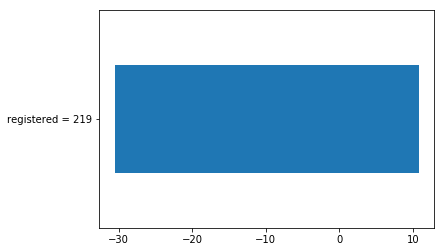

In [203]:

negative_shap.sort_values(ascending=True).plot(kind="barh", label="negative Shapley values", )
positive_shap.sort_values(ascending=True).plot(kind="barh", label="positive Shapley values", )

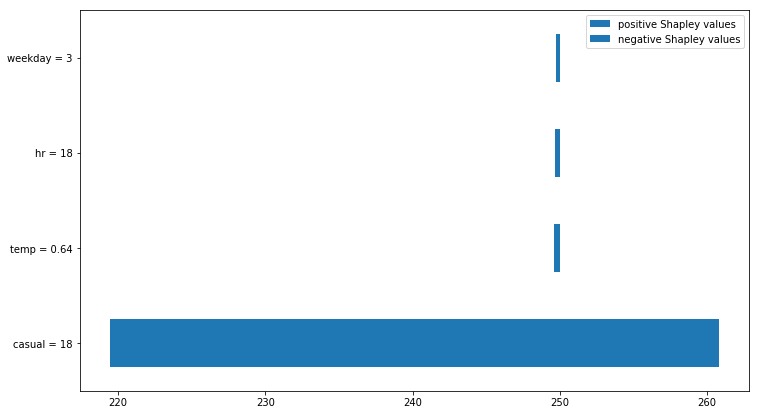

In [200]:
fig = plt.figure(figsize=(12,7))
# s_plot[col_selected].sort_values(ascending=True).plot(kind="barh", label="Shapley values")
positive_shap.sort_values(ascending=True).plot(kind="barh", label="positive Shapley values")
negative_shap.sort_values(ascending=True).plot(kind="barh", label="negative Shapley values")
# plt.vlines(fc(x.values) - mean_pred_ref, ymin=0, ymax=len(x)-1, colors="g", linestyles="--", label="x output")
# plt.vlines(0, ymin=0, ymax=len(x)-1, colors="purple", linestyles="--", label="mean ref output")
xticks_label = fig.get_axes()[0].get_xticks() + mean_pred_ref
xticks_label = xticks_label.astype(int)
fig.get_axes()[0].set_xticklabels(xticks_label)
plt.legend(loc='best')
plt.show()

In [184]:
(s_plot[col_selected] > 0)

casual = 18         False
registered = 219     True
temp = 0.64         False
hr = 18             False
weekday = 3         False
dtype: bool

In [187]:
s_plot.clip_upper(0)

/home/sgrah/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  """Entry point for launching an IPython kernel.


season = 3          -0.021108
mnth = 9             0.000000
hr = 18             -0.323277
holiday = 0          0.000000
weekday = 3         -0.260883
workingday = 1       0.000000
weathersit = 3      -0.130518
temp = 0.64         -0.413619
atemp = 0.5758       0.000000
hum = 0.89          -0.030423
windspeed = 0.0      0.000000
casual = 18        -30.557015
registered = 219     0.000000
dtype: float64

In [276]:
n_attributes = 5
pred_x = fc(x.values)
pred_ref = fc(reference.values)

x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
s_plot = pd.Series(data=mc_shap.values, index=x_attributes)
attributes = s_plot.abs().sort_values(ascending=False)[:n_attributes].index
s_plot = s_plot[attributes]
s_plot

registered = 219   -28.930763
casual = 18          7.868282
weathersit = 3      -0.313150
weekday = 3         -0.163023
hr = 18              0.126865
dtype: float64

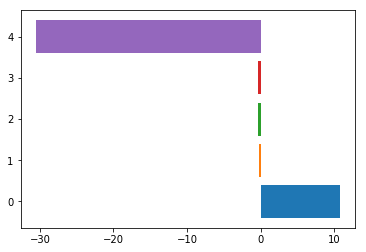

In [220]:
for idx, (attr, val) in enumerate(s_plot.sort_values(ascending=False).iteritems()):
    plt.barh(y=idx, width=val)

In [291]:
list(s_plot.sort_values(ascending=False).index)

['casual = 18', 'hr = 18', 'weekday = 3', 'weathersit = 3', 'registered = 219']

In [352]:
import seaborn as sns
sns.set_style("whitegrid")

In [361]:
my_cmap = plt.cm.RdBu


TypeError: 'LinearSegmentedColormap' object is not subscriptable

In [ ]:
my_cmap = plt.cm.RdBu(np.arange(plt.cm.RdBu.N))
my_cmap[:,0:3] *= a 
my_cmap = ListedColormap(my_cmap)

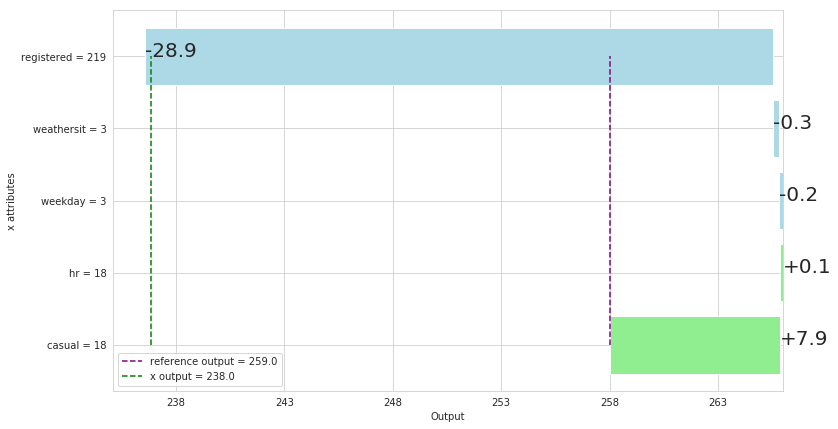

In [374]:
fig = plt.figure(figsize=(12,7))
# Shapley values
s_plot_sorted = s_plot.sort_values(ascending=False)
past_val = 0
for idx, (attr, val) in enumerate(s_plot_sorted.iteritems()):
    if val >= 0:
        plt.barh(y=idx+1, width=val, left=past_val, height=.8, color="lightgreen")
        plt.text(x=past_val + val, y=idx+1, s="+"+str(round(val,1)), fontsize=20)
    else:
        plt.barh(y=idx+1, width=val, left=past_val, height=.8, color="lightblue")
        plt.text(x=past_val + val, y=idx+1, s="-"+str(round(np.abs(val),1)), fontsize=20)
    past_val += val
fig.get_axes()[0].set_yticklabels(labels=[""] + list(s_plot_sorted.index))
# Display vertical lines for reference and x outputs
plt.vlines(0, ymin=1, ymax=len(attributes), colors="purple",
           linestyles="--", label="reference output = "+str(round(pred_ref,0)))
plt.vlines(pred_x - pred_ref, ymin=1, ymax=len(attributes), colors="g",
           linestyles="--", label="x output = "+str(round(pred_x,0)))

xticks_label = fig.get_axes()[0].get_xticks() + pred_ref
xticks_label = xticks_label.astype(int)
fig.get_axes()[0].set_xticklabels(xticks_label)
plt.legend(loc='best')
plt.xlabel("Output")
plt.ylabel("x attributes")
plt.show()

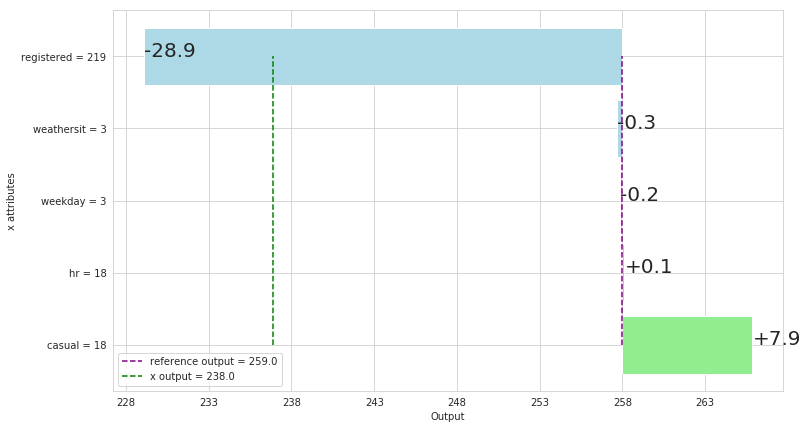

In [375]:
fig = plt.figure(figsize=(12,7))
# Shapley values
s_plot_sorted = s_plot.sort_values(ascending=False)
for idx, (attr, val) in enumerate(s_plot_sorted.iteritems()):
    if val >= 0:
        plt.barh(y=idx+1, width=val, left=0, height=.8, color="lightgreen")
        plt.text(x=val, y=idx+1, s="+"+str(round(val,1)), fontsize=20)
    else:
        plt.barh(y=idx+1, width=val, left=0, height=.8, color="lightblue")
        plt.text(x=val, y=idx+1, s="-"+str(round(np.abs(val),1)), fontsize=20)
    past_val += val
fig.get_axes()[0].set_yticklabels(labels=[""] + list(s_plot_sorted.index))
# Display vertical lines for reference and x outputs
plt.vlines(0, ymin=1, ymax=len(attributes), colors="purple",
           linestyles="--", label="reference output = "+str(round(pred_ref,0)))
plt.vlines(pred_x - pred_ref, ymin=1, ymax=len(attributes), colors="g",
           linestyles="--", label="x output = "+str(round(pred_x,0)))

xticks_label = fig.get_axes()[0].get_xticks() + pred_ref
xticks_label = xticks_label.astype(int)
fig.get_axes()[0].set_xticklabels(xticks_label)
plt.legend(loc='best')
plt.xlabel("Output")
plt.ylabel("x attributes")
plt.show()

In [270]:
mc_shap

-21.145360839899876

In [271]:
pred_x

237.6985782548691

In [272]:
pred_ref

258.8439390947694

In [273]:
pred_x - pred_ref

-21.14536083990029

In [ ]:
fig.get_axes()[0].set_yticklabels()

In [321]:
ax = fig.get_axes()[0]

# Comparison with several references 

In [18]:
n_ref = 100
idx_ref = np.random.choice(X_train.shape[0], size=n_ref).flatten()
pool_ref = X_train.iloc[idx_ref]
pool_ref.head(5)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
12364,2,6,9,0,1,1,1,0.62,0.6212,0.43,0.2836,38,244
4644,3,7,10,0,0,0,1,0.74,0.6818,0.60,0.2239,127,177
5344,3,8,14,0,1,1,1,0.74,0.6818,0.55,0.0896,56,95
15406,4,10,3,0,2,1,3,0.36,0.3333,0.87,0.2836,0,3
4760,3,7,6,0,5,1,1,0.76,0.7424,0.75,0.0896,13,83


In [19]:
x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
pool_shapley = pd.DataFrame(np.zeros((n_ref, d+1)), columns=["ref_pred"] + x_attributes)
for i in range(n_ref):
    r = pool_ref.iloc[i]
    ref_pred = fc(r.values)
    pool_shapley.iloc[i,0] = ref_pred
    mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=100)
    pool_shapley.iloc[i,1:] = mc_shap.values

  4%|▍         | 4/100 [00:00<00:02, 36.94it/s]

new dimension 11


  5%|▌         | 5/100 [00:00<00:02, 45.59it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 52.99it/s]

new dimension 11


  9%|▉         | 9/100 [00:00<00:01, 89.08it/s]

new dimension 7


  6%|▌         | 6/100 [00:00<00:01, 58.98it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 56.83it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 73.42it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 51.87it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 68.43it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 79.87it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 59.38it/s]

new dimension 12


  6%|▌         | 6/100 [00:00<00:01, 59.71it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 63.04it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 55.58it/s]

new dimension 12


  4%|▍         | 4/100 [00:00<00:02, 36.48it/s]

new dimension 12


  6%|▌         | 6/100 [00:00<00:01, 58.18it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 68.24it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 57.72it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 73.74it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 70.34it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 77.35it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 63.59it/s]

new dimension 11


  5%|▌         | 5/100 [00:00<00:01, 48.73it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 76.08it/s]

new dimension 9


  9%|▉         | 9/100 [00:00<00:01, 82.99it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 61.99it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 52.83it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 58.00it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.97it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 63.99it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 66.88it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.38it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 75.11it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 71.58it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 58.10it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 67.08it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 71.66it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 68.30it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.82it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 65.92it/s]

new dimension 12


  9%|▉         | 9/100 [00:00<00:01, 84.76it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 75.04it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 54.43it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 78.22it/s]

new dimension 9


  6%|▌         | 6/100 [00:00<00:01, 59.95it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 72.32it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.95it/s]

new dimension 12


  6%|▌         | 6/100 [00:00<00:01, 54.76it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 73.84it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 62.74it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 59.80it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 59.31it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 55.96it/s]

new dimension 12


 10%|█         | 10/100 [00:00<00:01, 88.81it/s]

new dimension 9


  5%|▌         | 5/100 [00:00<00:02, 41.77it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 58.45it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 65.79it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:02, 42.58it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 58.58it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 67.60it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 63.00it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.96it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:02, 45.42it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 64.26it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 73.36it/s]

new dimension 10


  9%|▉         | 9/100 [00:00<00:01, 89.21it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 68.33it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 72.37it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 74.66it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:02, 46.00it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 67.91it/s]

new dimension 9


  8%|▊         | 8/100 [00:00<00:01, 69.85it/s]

new dimension 9


  5%|▌         | 5/100 [00:00<00:01, 47.96it/s]

new dimension 11


  5%|▌         | 5/100 [00:00<00:02, 45.74it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 55.88it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 76.05it/s]

new dimension 10


  9%|▉         | 9/100 [00:00<00:01, 85.76it/s]

new dimension 9


  5%|▌         | 5/100 [00:00<00:02, 47.05it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 62.43it/s]

new dimension 8


  7%|▋         | 7/100 [00:00<00:01, 63.10it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 74.74it/s]

new dimension 11


  9%|▉         | 9/100 [00:00<00:01, 83.12it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 78.37it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 76.27it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.43it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 66.88it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 71.22it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 63.73it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 75.21it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:01, 49.23it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.46it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 78.64it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 72.66it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 74.19it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.93it/s]

new dimension 11


  9%|▉         | 9/100 [00:00<00:01, 89.52it/s]

new dimension 8


  8%|▊         | 8/100 [00:00<00:01, 74.92it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 68.50it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.66it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 67.56it/s]

new dimension 11


100%|██████████| 100/100 [00:01<00:00, 69.18it/s]


In [23]:
mean_pool_shap = pool_shapley.mean(axis=0)
mean_pool_shap

ref_pred              188.825460
season = 4             -0.020718
mnth = 11              -0.168149
hr = 16                -0.232629
holiday = 0            -0.000749
weekday = 2             0.162369
workingday = 1          0.000000
weathersit = 3         -0.154543
temp = 0.4              0.147763
atemp = 0.4091          0.087542
hum = 0.87             -0.200309
windspeed = 0.2239     -0.037933
casual = 5            -28.241096
registered = 146       -8.668812
dtype: float64

In [24]:
np.sum(mean_pool_shap)

151.49819452844727

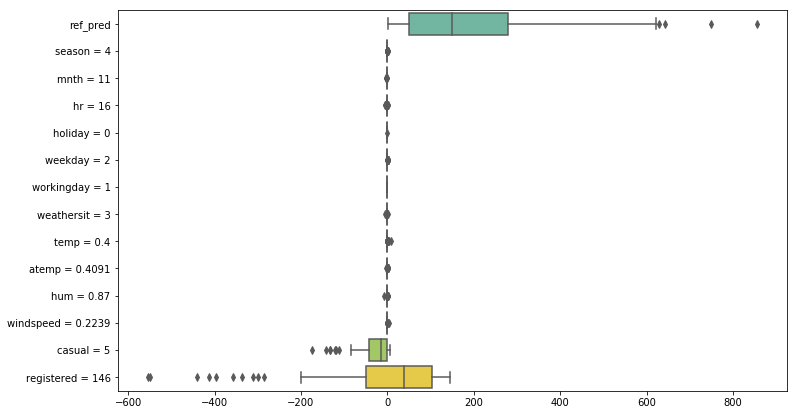

In [27]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=pool_shapley, orient="h", palette="Set2")
plt.show()